In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import textwrap


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import model_utility, visuals_utility, color_utility

import warnings

from pandas.core.generic import SettingWithCopyWarning

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

### Data

In [2]:
original_df = pd.read_csv("https://projects.fivethirtyeight.com/nfl-api/nfl_elo.csv")
original_df

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
0,1920-09-26,1920,0,NaN,RII,STP,1503.947000,1300.000000,0.824651,0.175349,...,NaN,NaN,NaN,NaN,NaN,48,0,NaN,NaN,NaN
1,1920-10-03,1920,0,NaN,AKR,WHE,1503.420000,1300.000000,0.824212,0.175788,...,NaN,NaN,NaN,NaN,NaN,43,0,NaN,NaN,NaN
2,1920-10-03,1920,0,NaN,BFF,WBU,1478.004000,1300.000000,0.802000,0.198000,...,NaN,NaN,NaN,NaN,NaN,32,6,NaN,NaN,NaN
3,1920-10-03,1920,0,NaN,DAY,COL,1493.002000,1504.908000,0.575819,0.424181,...,NaN,NaN,NaN,NaN,NaN,14,0,NaN,NaN,NaN
4,1920-10-03,1920,0,NaN,RII,MUN,1516.108000,1478.004000,0.644171,0.355829,...,NaN,NaN,NaN,NaN,NaN,45,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2023-01-22,2022,0,d,BUF,CIN,1731.516093,1690.292481,0.648277,0.351723,...,303.726984,225.069808,230.466056,1675.570770,1690.152492,10,27,99.0,100.0,100.0
17375,2023-01-22,2022,0,d,SF,DAL,1708.971847,1640.135262,0.683613,0.316387,...,105.114287,109.133365,191.883277,1719.153115,1619.647034,19,12,98.0,100.0,99.0
17376,2023-01-29,2022,0,c,PHI,SF,1621.987292,1721.375447,0.450672,0.549328,...,56.917741,246.826740,103.911803,1645.507079,1693.213858,31,7,99.0,100.0,100.0
17377,2023-01-29,2022,0,c,KC,CIN,1735.804844,1729.668918,0.600966,0.399034,...,28.185998,280.177715,210.238050,1708.664922,1678.805820,23,20,100.0,100.0,100.0


In [3]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            17379 non-null  object 
 1   season          17379 non-null  int64  
 2   neutral         17379 non-null  int64  
 3   playoff         616 non-null    object 
 4   team1           17379 non-null  object 
 5   team2           17379 non-null  object 
 6   elo1_pre        17379 non-null  float64
 7   elo2_pre        17379 non-null  float64
 8   elo_prob1       17379 non-null  float64
 9   elo_prob2       17379 non-null  float64
 10  elo1_post       17379 non-null  float64
 11  elo2_post       17379 non-null  float64
 12  qbelo1_pre      15217 non-null  float64
 13  qbelo2_pre      15217 non-null  float64
 14  qb1             15217 non-null  object 
 15  qb2             15217 non-null  object 
 16  qb1_value_pre   15217 non-null  float64
 17  qb2_value_pre   15217 non-null 

In [4]:
original_df[['season','importance']].loc[~original_df['importance'].isna()]

,season,importance
16810,2021,46.0
16811,2021,35.0
16812,2021,56.0
16813,2021,70.0
16814,2021,64.0
...,...,...
17374,2022,100.0
17375,2022,100.0
17376,2022,100.0
17377,2022,100.0


In [5]:
original_df.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'quality',
       'importance', 'total_rating'],
      dtype='object')

In [6]:
# selecting only features that will be used for analysis and modeling
features = [ 'season', 'team1', 'team2', 'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 
       'qbelo1_pre', 'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2', 'quality',
       'score1', 'score2']

In [7]:
df = original_df[features].copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15217 entries, 0 to 15216
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       15217 non-null  int64  
 1   team1        15217 non-null  object 
 2   team2        15217 non-null  object 
 3   elo1_pre     15217 non-null  float64
 4   elo2_pre     15217 non-null  float64
 5   elo_prob1    15217 non-null  float64
 6   elo_prob2    15217 non-null  float64
 7   qbelo1_pre   15217 non-null  float64
 8   qbelo2_pre   15217 non-null  float64
 9   qbelo_prob1  15217 non-null  float64
 10  qbelo_prob2  15217 non-null  float64
 11  quality      15217 non-null  float64
 12  score1       15217 non-null  int64  
 13  score2       15217 non-null  int64  
dtypes: float64(9), int64(3), object(2)
memory usage: 1.6+ MB


In [9]:
# deriving the target based on scores of the game
df['winner'] = (df['score1'] > df['score2']).astype(int)

# exporting the final dataset with features - including scores and teams as 
# references even though it will not be used in modeling.
df.to_csv("../data/final_nfl_elo.csv")

### Let see if we have any outliers and remove them from data

In [10]:

selected_features = ['season','elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 
      'qbelo1_pre', 'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2', 'quality']
selected_df = df[selected_features]

# Calculate the IQR
Q1 = selected_df.quantile(0.25)
Q3 = selected_df.quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5

# Identify outliers
outliers = ((selected_df < (Q1 - threshold * IQR)) | (selected_df > (Q3 + threshold * IQR))).any(axis=1)

print(f"Outliers found: \n{outliers.value_counts()}")

# Remove outliers from the dataset
non_outliers_df = df[~outliers]
non_outliers_df


Outliers found: 
False    15161
True        56
Name: count, dtype: int64


,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,quality,score1,score2,winner
0,1950,PHI,CLE,1674.314000,1647.304000,0.629402,0.370598,1672.671374,1643.768931,0.620653,0.379347,98.0,10,35,0
1,1950,BCL,WSH,1337.541000,1454.448000,0.425851,0.574149,1337.632585,1454.722542,0.425357,0.574643,6.0,14,38,0
2,1950,PIT,NYG,1485.849000,1461.717000,0.625529,0.374471,1485.701701,1462.405630,0.612587,0.387413,35.0,7,18,0
3,1950,GB,DET,1353.646000,1449.128000,0.456245,0.543755,1354.399933,1449.703511,0.443900,0.556100,7.0,7,45,0
4,1950,LAR,CHI,1564.606000,1628.688000,0.501321,0.498679,1564.941808,1628.083975,0.498518,0.501482,88.0,20,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15212,2022,BUF,CIN,1731.516093,1690.292481,0.648277,0.351723,1714.417123,1651.306140,0.641191,0.358809,99.0,10,27,0
15213,2022,SF,DAL,1708.971847,1640.135262,0.683613,0.316387,1702.555028,1636.245121,0.589496,0.410504,98.0,19,12,1
15214,2022,PHI,SF,1621.987292,1721.375447,0.450672,0.549328,1619.567823,1719.153115,0.586019,0.413981,99.0,31,7,1
15215,2022,KC,CIN,1735.804844,1729.668918,0.600966,0.399034,1697.318250,1690.152492,0.580287,0.419713,100.0,23,20,1


### Modeling

#### Split data for training and testing

In [11]:
# split the X and y
#X_features = [ 'elo1_pre', 'elo2_pre', 'elo_prob1', 'elo_prob2', 'qbelo1_pre', 'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2', 'quality' ]
X_features = [ 'elo1_pre', 'elo2_pre', 'qbelo1_pre', 'qbelo2_pre',  'quality' ]

target = 'winner'

In [12]:
X = non_outliers_df[X_features].copy()
y = non_outliers_df[target]

In [13]:
# check the distribution of y, which in this case is pretty good with 
# 57 and 43 percent almost evenly distributed
print(y.value_counts())
print("\nTarget Percentage (0 vs 1)")
print((y.value_counts() / len(y)) * 100)

winner
1    8606
0    6555
Name: count, dtype: int64

Target Percentage (0 vs 1)
winner
1    56.764066
0    43.235934
Name: count, dtype: float64


#### Model Selection

In [14]:
# function to convert model results dictionary to dataframe
def results_to_df(mresults):
    model_df = pd.DataFrame(mresults).T.reset_index()
    model_df.columns = ['model', 'model_details', 'train_score', 'accuracy_score', 'balanced_accuracy_score', 'confusion_matrix', 'classification_report']
    return model_df

In [15]:
base_estimator = DecisionTreeClassifier(max_depth=2)

eval_models = {
    "Logistic Regression" : LogisticRegression(random_state=42), 
    "AdaBoostClassifier" : AdaBoostClassifier(estimator=base_estimator, \
                                              n_estimators=128, random_state=42),
    "SVC" : SVC(kernel='poly', probability=True), 
    "KNeighbors Classifier" : KNeighborsClassifier(n_neighbors=5), 
    "DecisionTree Classifier" : DecisionTreeClassifier(), 
    "RandomForest Classifier" : RandomForestClassifier(n_estimators=256, random_state=42)
}

In [16]:
# process with multiple models and see which has better accuracy
model_results = model_utility.process_models_Xy(eval_models, X, y)
results_to_df(model_results)

,model,model_details,train_score,accuracy_score,balanced_accuracy_score,confusion_matrix,classification_report
0,Logistic Regression,LogisticRegression(random_state=42),0.64934,0.655764,0.634088,"[[791, 813], [492, 1695]]",precision recall f1-score ...
1,AdaBoostClassifier,"(DecisionTreeClassifier(max_depth=2, random_st...",0.689094,0.628858,0.611018,"[[794, 810], [597, 1590]]",precision recall f1-score ...
2,SVC,"SVC(kernel='poly', probability=True)",0.615391,0.616988,0.558849,"[[290, 1314], [138, 2049]]",precision recall f1-score ...
3,KNeighbors Classifier,KNeighborsClassifier(),0.735092,0.595621,0.581713,"[[788, 816], [717, 1470]]",precision recall f1-score ...
4,DecisionTree Classifier,DecisionTreeClassifier(),0.999912,0.566341,0.559826,"[[830, 774], [870, 1317]]",precision recall f1-score ...
5,RandomForest Classifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.999912,0.620681,0.605177,"[[809, 795], [643, 1544]]",precision recall f1-score ...


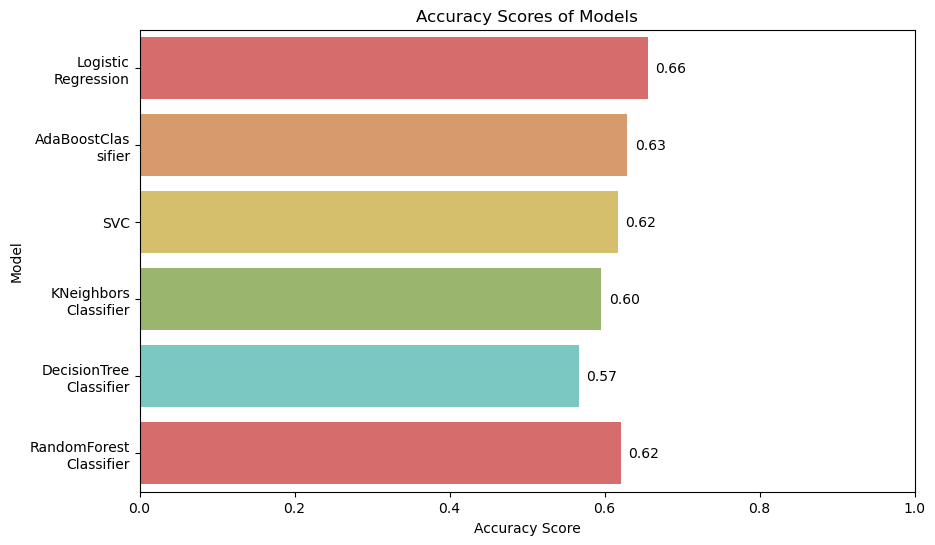

In [17]:
# visual representation of accuracy scores
visuals_utility.show_accuracy_scores({m_name:m_data['accuracy_score'] for m_name, m_data in model_results.items()})

In [18]:
coefficients = pd.DataFrame(model_results['Logistic Regression']['model'].coef_, columns=X.columns)
coefficients

,elo1_pre,elo2_pre,qbelo1_pre,qbelo2_pre,quality
0,0.223221,-0.109308,0.338672,-0.459105,0.043223


### Now lets add couple more derived features and see if it improves the model

In [19]:
# add team and quarter back pre ELO ratings difference
non_outliers_df['elo_diff'] = (non_outliers_df['elo1_pre'] - non_outliers_df['elo2_pre'])
non_outliers_df['qbelo_diff'] = (non_outliers_df['qbelo1_pre'] - non_outliers_df['qbelo2_pre'])

X_features.append('elo_diff')
X_features.append('qbelo_diff')

X_features

['elo1_pre',
 'elo2_pre',
 'qbelo1_pre',
 'qbelo2_pre',
 'quality',
 'elo_diff',
 'qbelo_diff']

In [20]:
# process with new features 
X1 = non_outliers_df[X_features]

model1_results = model_utility.process_models_Xy(eval_models, X1, y)

results_to_df(model1_results)

,model,model_details,train_score,accuracy_score,balanced_accuracy_score,confusion_matrix,classification_report
0,Logistic Regression,LogisticRegression(random_state=42),0.64934,0.656027,0.6344,"[[792, 812], [492, 1695]]",precision recall f1-score ...
1,AdaBoostClassifier,"(DecisionTreeClassifier(max_depth=2, random_st...",0.689534,0.625692,0.608773,"[[800, 804], [615, 1572]]",precision recall f1-score ...
2,SVC,"SVC(kernel='poly', probability=True)",0.615215,0.618307,0.560241,"[[293, 1311], [136, 2051]]",precision recall f1-score ...
3,KNeighbors Classifier,KNeighborsClassifier(),0.733245,0.601161,0.58801,"[[806, 798], [714, 1473]]",precision recall f1-score ...
4,DecisionTree Classifier,DecisionTreeClassifier(),0.999912,0.5579,0.547275,"[[767, 837], [839, 1348]]",precision recall f1-score ...
5,RandomForest Classifier,"(DecisionTreeClassifier(max_features='sqrt', r...",0.999912,0.620153,0.605883,"[[823, 781], [659, 1528]]",precision recall f1-score ...


In [21]:
coefficients1 = pd.DataFrame(model1_results['Logistic Regression']['model'].coef_, columns=X1.columns)
coefficients1

,elo1_pre,elo2_pre,qbelo1_pre,qbelo2_pre,quality,elo_diff,qbelo_diff
0,0.133029,-0.024081,0.13474,-0.25506,0.043091,0.11571,0.283741


#### Derive to see which team ELO rating favors and use that features to train

In [22]:
# derive who is favored in pre rating 
non_outliers_df['elo_pre'] = (non_outliers_df['elo1_pre'] > non_outliers_df['elo2_pre']).astype(int)
non_outliers_df['qbelo_pre'] = (non_outliers_df['qbelo1_pre'] > non_outliers_df['qbelo2_pre']).astype(int)
non_outliers_df

,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,quality,score1,score2,winner,elo_diff,qbelo_diff,elo_pre,qbelo_pre
0,1950,PHI,CLE,1674.314000,1647.304000,0.629402,0.370598,1672.671374,1643.768931,0.620653,0.379347,98.0,10,35,0,27.010000,28.902443,1,1
1,1950,BCL,WSH,1337.541000,1454.448000,0.425851,0.574149,1337.632585,1454.722542,0.425357,0.574643,6.0,14,38,0,-116.907000,-117.089957,0,0
2,1950,PIT,NYG,1485.849000,1461.717000,0.625529,0.374471,1485.701701,1462.405630,0.612587,0.387413,35.0,7,18,0,24.132000,23.296071,1,1
3,1950,GB,DET,1353.646000,1449.128000,0.456245,0.543755,1354.399933,1449.703511,0.443900,0.556100,7.0,7,45,0,-95.482000,-95.303577,0,0
4,1950,LAR,CHI,1564.606000,1628.688000,0.501321,0.498679,1564.941808,1628.083975,0.498518,0.501482,88.0,20,24,0,-64.082000,-63.142167,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15212,2022,BUF,CIN,1731.516093,1690.292481,0.648277,0.351723,1714.417123,1651.306140,0.641191,0.358809,99.0,10,27,0,41.223612,63.110983,1,1
15213,2022,SF,DAL,1708.971847,1640.135262,0.683613,0.316387,1702.555028,1636.245121,0.589496,0.410504,98.0,19,12,1,68.836585,66.309907,1,1
15214,2022,PHI,SF,1621.987292,1721.375447,0.450672,0.549328,1619.567823,1719.153115,0.586019,0.413981,99.0,31,7,1,-99.388154,-99.585292,0,0
15215,2022,KC,CIN,1735.804844,1729.668918,0.600966,0.399034,1697.318250,1690.152492,0.580287,0.419713,100.0,23,20,1,6.135927,7.165757,1,1


In [23]:
# process with new features
X_Subset = ['elo_pre', 'qbelo_pre', 'elo_prob1', 'elo_prob2', 'qbelo_prob1', 'qbelo_prob2']

X2 = non_outliers_df[X_Subset]

model2_results = model_utility.process_models_Xy(eval_models, X2, y)
results_to_df(model2_results)

,model,model_details,train_score,accuracy_score,balanced_accuracy_score,confusion_matrix,classification_report
0,Logistic Regression,LogisticRegression(random_state=42),0.657432,0.64785,0.6259,"[[775, 829], [506, 1681]]",precision recall f1-score ...
1,AdaBoostClassifier,"(DecisionTreeClassifier(max_depth=2, random_st...",0.680299,0.63387,0.615029,"[[790, 814], [574, 1613]]",precision recall f1-score ...
2,SVC,"SVC(kernel='poly', probability=True)",0.642744,0.633078,0.633539,"[[1021, 583], [808, 1379]]",precision recall f1-score ...
3,KNeighbors Classifier,KNeighborsClassifier(),0.73905,0.609865,0.594391,"[[792, 812], [667, 1520]]",precision recall f1-score ...
4,DecisionTree Classifier,DecisionTreeClassifier(),1.0,0.579794,0.571568,"[[831, 773], [820, 1367]]",precision recall f1-score ...
5,RandomForest Classifier,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0,0.611976,0.597716,"[[810, 794], [677, 1510]]",precision recall f1-score ...


In [24]:
coefficients2 = pd.DataFrame(model2_results['Logistic Regression']['model'].coef_, columns=X2.columns)
coefficients2

,elo_pre,qbelo_pre,elo_prob1,elo_prob2,qbelo_prob1,qbelo_prob2
0,-0.027207,-0.002181,0.026092,-0.026092,0.380418,-0.380418


#### Add a feature that calculates team 1 (home team) probability to win 

In [25]:
# lets add a probability that team a can win which is ELO formula
def elo_win_probability(elo_diff):
    return 1 / (10 ** (-elo_diff / 400) + 1)

non_outliers_df['team1_prob'] = non_outliers_df['elo_diff'].apply(elo_win_probability)
non_outliers_df

,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,quality,score1,score2,winner,elo_diff,qbelo_diff,elo_pre,qbelo_pre,team1_prob
0,1950,PHI,CLE,1674.314000,1647.304000,0.629402,0.370598,1672.671374,1643.768931,0.620653,0.379347,98.0,10,35,0,27.010000,28.902443,1,1,0.538792
1,1950,BCL,WSH,1337.541000,1454.448000,0.425851,0.574149,1337.632585,1454.722542,0.425357,0.574643,6.0,14,38,0,-116.907000,-117.089957,0,0,0.337832
2,1950,PIT,NYG,1485.849000,1461.717000,0.625529,0.374471,1485.701701,1462.405630,0.612587,0.387413,35.0,7,18,0,24.132000,23.296071,1,1,0.534673
3,1950,GB,DET,1353.646000,1449.128000,0.456245,0.543755,1354.399933,1449.703511,0.443900,0.556100,7.0,7,45,0,-95.482000,-95.303577,0,0,0.365948
4,1950,LAR,CHI,1564.606000,1628.688000,0.501321,0.498679,1564.941808,1628.083975,0.498518,0.501482,88.0,20,24,0,-64.082000,-63.142167,0,0,0.408810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15212,2022,BUF,CIN,1731.516093,1690.292481,0.648277,0.351723,1714.417123,1651.306140,0.641191,0.358809,99.0,10,27,0,41.223612,63.110983,1,1,0.559049
15213,2022,SF,DAL,1708.971847,1640.135262,0.683613,0.316387,1702.555028,1636.245121,0.589496,0.410504,98.0,19,12,1,68.836585,66.309907,1,1,0.597788
15214,2022,PHI,SF,1621.987292,1721.375447,0.450672,0.549328,1619.567823,1719.153115,0.586019,0.413981,99.0,31,7,1,-99.388154,-99.585292,0,0,0.360747
15215,2022,KC,CIN,1735.804844,1729.668918,0.600966,0.399034,1697.318250,1690.152492,0.580287,0.419713,100.0,23,20,1,6.135927,7.165757,1,1,0.508829


In [26]:
non_outliers_df.columns

Index(['season', 'team1', 'team2', 'elo1_pre', 'elo2_pre', 'elo_prob1',
       'elo_prob2', 'qbelo1_pre', 'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2',
       'quality', 'score1', 'score2', 'winner', 'elo_diff', 'qbelo_diff',
       'elo_pre', 'qbelo_pre', 'team1_prob'],
      dtype='object')

In [27]:
# process by adding new features
X_features = ['elo1_pre', 'elo2_pre', 'elo_prob1',
       'elo_prob2', 'qbelo1_pre', 'qbelo2_pre', 'qbelo_prob1', 'qbelo_prob2',
       'quality', 'elo_diff', 'qbelo_diff',
       'elo_pre', 'qbelo_pre', 'team1_prob']

X3 = non_outliers_df[X_features]

model3_results = model_utility.process_models_Xy(eval_models, X3, y)
results_to_df(model3_results)

,model,model_details,train_score,accuracy_score,balanced_accuracy_score,confusion_matrix,classification_report
0,Logistic Regression,LogisticRegression(random_state=42),0.657168,0.646531,0.627167,"[[804, 800], [540, 1647]]",precision recall f1-score ...
1,AdaBoostClassifier,"(DecisionTreeClassifier(max_depth=2, random_st...",0.692612,0.620944,0.600337,"[[748, 856], [581, 1606]]",precision recall f1-score ...
2,SVC,"SVC(kernel='poly', probability=True)",0.645558,0.634925,0.636303,"[[1035, 569], [815, 1372]]",precision recall f1-score ...
3,KNeighbors Classifier,KNeighborsClassifier(),0.733773,0.600369,0.583751,"[[763, 841], [674, 1513]]",precision recall f1-score ...
4,DecisionTree Classifier,DecisionTreeClassifier(),1.0,0.557109,0.548167,"[[786, 818], [861, 1326]]",precision recall f1-score ...
5,RandomForest Classifier,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0,0.627011,0.60975,"[[798, 806], [608, 1579]]",precision recall f1-score ...


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize Logistic Regression model
model = LogisticRegression()

# Initialize Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit Grid Search to training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on test data
test_score = grid_search.score(X_test, y_test)
print("Test Score:", test_score)


Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.6559197355113419
Test Score: 0.6508407517309595


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Initialize AdaBoostClassifier model
model = AdaBoostClassifier()

# Initialize Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit Grid Search to training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on test data
test_score = grid_search.score(X_test, y_test)
print("Test Score:", test_score)


Best Parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best Score: 0.6574033876985577
Test Score: 0.648203099241675


In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto']
}

# Initialize SVC
model = SVC()

# Initialize Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit Grid Search to training data
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on test data
test_score = grid_search.score(X_test, y_test)
print("Test Score:", test_score)


Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.6546003178623334
Test Score: 0.6571051763930102


In [33]:
coefficients3 = pd.DataFrame(model3_results['Logistic Regression']['model'].coef_, columns=X3.columns)
coefficients3

,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,quality,elo_diff,qbelo_diff,elo_pre,qbelo_pre,team1_prob
0,0.439938,-0.314498,-0.413925,0.413925,-0.087255,-0.08786,0.3725,-0.3725,0.060818,0.55305,-0.000648,0.006793,0.017012,-0.192984


In [53]:
lr_model = {"LR Model" : LogisticRegression(C=10, penalty='l1', solver='liblinear')} 

X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

lr_model_results = model_utility.process_models(lr_model, X_train, X_test, y_train, y_test)
lr_model_results

{'LR Model': {'model': LogisticRegression(C=10, penalty='l1', solver='liblinear'),
  'train_score': 0.6568271767810027,
  'accuracy_score': 0.6505110451697989,
  'balanced_accuracy_score': 0.6301940770185714,
  'confusion_matrix': array([[ 641,  633],
         [ 427, 1332]]),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.60      0.50      0.55      1274\n           1       0.68      0.76      0.72      1759\n\n    accuracy                           0.65      3033\n   macro avg       0.64      0.63      0.63      3033\nweighted avg       0.65      0.65      0.64      3033\n'}}

#### Considering the accuracy score Logistic Regression, SVC and AdaBoostClassifier have around same accuracy which make any one of them as a good model for this dataset. Logistic Regression seems to be better fit for this and we are going to explore more using that model. Also try to explore more on features and implement feature engineering and see if it helps to optimize the model.

In [54]:
# Cross Value scores for Logistic Regression
scores = cross_val_score(lr_model['LR Model'], X3, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", scores)

print("Mean accuracy:", scores.mean())
print("Standard deviation of accuracy:", scores.std())

Cross-validation scores: [0.67194197 0.66094987 0.6378628  0.6444591  0.65435356]
Mean accuracy: 0.6539134602921078
Standard deviation of accuracy: 0.01201449638315885


Let's use predicting probabilites using Logistic Regression and see how it predicted based on each feature.

In [55]:
# get predict proba for X_test .
predicted_probabilities = lr_model_results['LR Model']['model'].predict_proba(X_test)

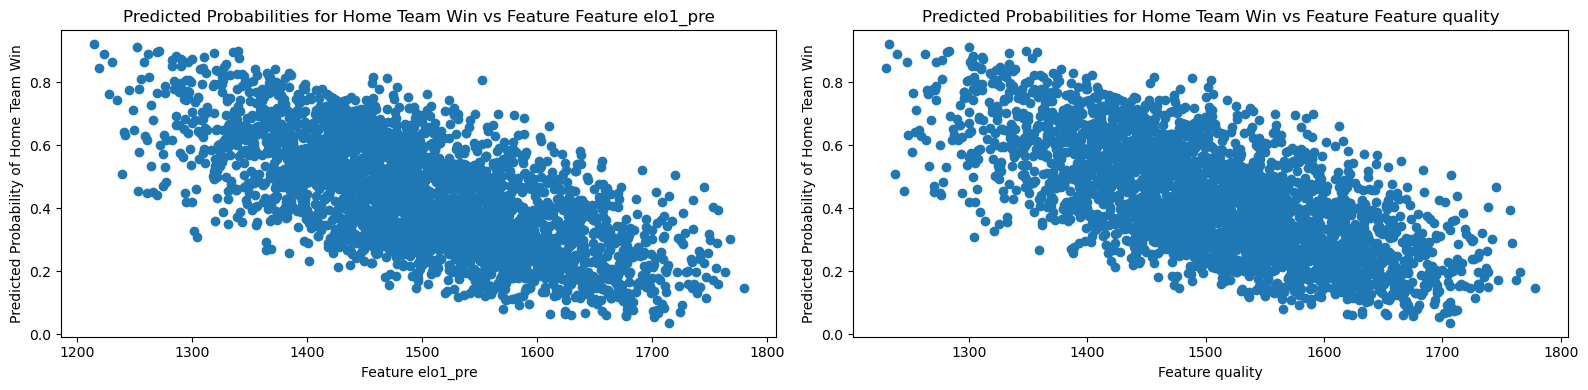

In [56]:
# Plot home team win probabilities
positive_class_probabilities = predicted_probabilities[:, 0]

# Plot only elo rating features of home team
num_features = [0, 4]

num_rows = (len(num_features) + 1) // 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, 4 * num_rows))
axes = axes.flatten()

# Plot the predicted probabilities against each feature
for i, feature_index in enumerate(num_features):
    axes[i].scatter(X_test.iloc[:, feature_index], positive_class_probabilities)
    axes[i].set_xlabel(f'Feature {X.columns[feature_index]}')
    axes[i].set_ylabel('Predicted Probability of Home Team Win')
    axes[i].set_title(f'Predicted Probabilities for Home Team Win vs Feature Feature {X.columns[feature_index]}')

# Hide any unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [57]:
print("Logisitic Regression Classification Report")
print(lr_model_results['LR Model']['classification_report'])

Logisitic Regression Classification Report
              precision    recall  f1-score   support

           0       0.60      0.50      0.55      1274
           1       0.68      0.76      0.72      1759

    accuracy                           0.65      3033
   macro avg       0.64      0.63      0.63      3033
weighted avg       0.65      0.65      0.64      3033



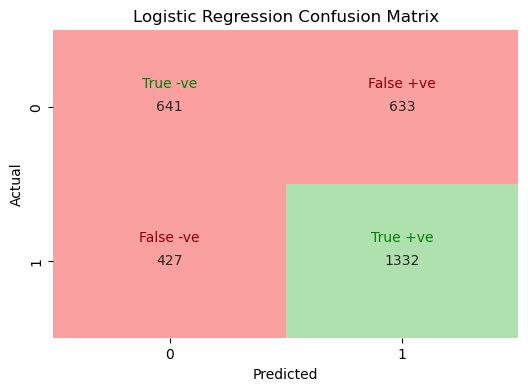

In [58]:
visuals_utility.single_binary_confusion_matrix(lr_model_results['LR Model']['confusion_matrix'], "Logistic Regression")

### Let us process data by splitting by teams with 500 or more games and run the models.

In [59]:
home_teams_groups = non_outliers_df.groupby('team1')
home_teams_size = non_outliers_df.groupby('team1').size()
home_teams_with_more_than_500_games = home_teams_size[home_teams_size > 500].index.tolist()
print(len(home_teams_with_more_than_500_games))
home_df = non_outliers_df[non_outliers_df['team1'].isin(home_teams_with_more_than_500_games)]
home_df.shape

17


(9244, 20)

In [60]:
visit_teams_groups = non_outliers_df.groupby('team2')
visit_teams_size = non_outliers_df.groupby('team2').size()
visit_teams_with_more_than_500_games = visit_teams_size[visit_teams_size > 500].index.tolist()
print(len(visit_teams_with_more_than_500_games))
visit_df = non_outliers_df[non_outliers_df['team2'].isin(visit_teams_with_more_than_500_games)]
visit_df.shape

17


(9208, 20)

We can see that Home teams have more advantage and wins compared to visiting teams. 

In [61]:
# model by team when plainning home vs visiting
home_team_df = pd.DataFrame()
visit_team_df = pd.DataFrame()

In [65]:
# predict accuracy for each team 
def process_each_team(eachTeamDf):
      '''
         helper method to process each team and get accuracy score
         and other metrics
      '''     
      X = eachTeamDf[X_features].copy()
      y = eachTeamDf[target]

      if (len(y.unique())) > 1:

         model_results = model_utility.process_models_Xy(lr_model, X, y)

         return model_results
      

In [66]:
# process home and visiting teams data to see the trends
home_team_details = {
    'team' : [],
    'average_elo_pre' : [], 
    'average_elo_prob' : [] , 
    'total_games' : [], 
    'wins' : [],
    'LR_accuracy' : []
}

visit_team_details = {
    'team' : [],
    'average_elo_pre' : [], 
    'average_elo_prob' : [] , 
    'total_games' : [], 
    'wins' : [],
    'LR_accuracy' : []
}

for eachTeam in home_teams_with_more_than_500_games:
    team_df = home_teams_groups.get_group(eachTeam)

    model_results = process_each_team(team_df)

    if model_results != None:
        home_team_details['team'].append(eachTeam)
        home_team_details['average_elo_pre'].append(team_df['elo1_pre'].mean())
        home_team_details['average_elo_prob'].append(team_df['elo_prob1'].mean())
        home_team_details['total_games'].append(len(team_df))
        home_team_details['wins'].append(len(team_df.loc[team_df['score1'] > team_df['score2']]))
    
        for m_name, m_data in model_results.items():
            if m_name == 'LR Model':
                home_team_details['LR_accuracy'].append(round(m_data['accuracy_score'], 5))

for eachTeam in visit_teams_with_more_than_500_games:
    team_df = visit_teams_groups.get_group(eachTeam)
    
    model_results = process_each_team(team_df)

    if model_results != None:
        visit_team_details['team'].append(eachTeam)
        visit_team_details['average_elo_pre'].append(team_df['elo2_pre'].mean())
        visit_team_details['average_elo_prob'].append(team_df['elo_prob2'].mean())
        visit_team_details['total_games'].append(len(team_df))
        visit_team_details['wins'].append(len(team_df.loc[team_df['score1'] < team_df['score2']]))
    
        for m_name, m_data in model_results.items():
            if m_name == 'LR Model':
                visit_team_details['LR_accuracy'].append(round(m_data['accuracy_score'], 5))

In [68]:
# identify top 20 teams and see the trend 
home_team_df = pd.DataFrame(home_team_details)
top_home_teams = home_team_df.sort_values(by='wins', ascending=False).iloc[:20]
top_home_teams['win_per'] = round(((top_home_teams['wins']/top_home_teams['total_games']) * 100), 2)
top_home_teams

,team,average_elo_pre,average_elo_prob,total_games,wins,LR_accuracy,win_per
14,PIT,1543.544820,0.628588,579,374,0.73103,64.59
7,GB,1532.112378,0.619962,569,359,0.70629,63.09
15,SF,1534.163031,0.614370,580,344,0.64138,59.31
4,DAL,1553.396956,0.638649,516,330,0.62791,63.95
11,NE,1538.860426,0.623631,510,321,0.72656,62.94
5,DEN,1522.126971,0.598752,510,318,0.70312,62.35
10,LAR,1515.656668,0.591887,565,316,0.66197,55.93
13,PHI,1515.412016,0.591048,567,313,0.54930,55.20
2,CHI,1502.149719,0.582742,557,312,0.62857,56.01
8,IND,1514.704226,0.594616,542,311,0.62500,57.38


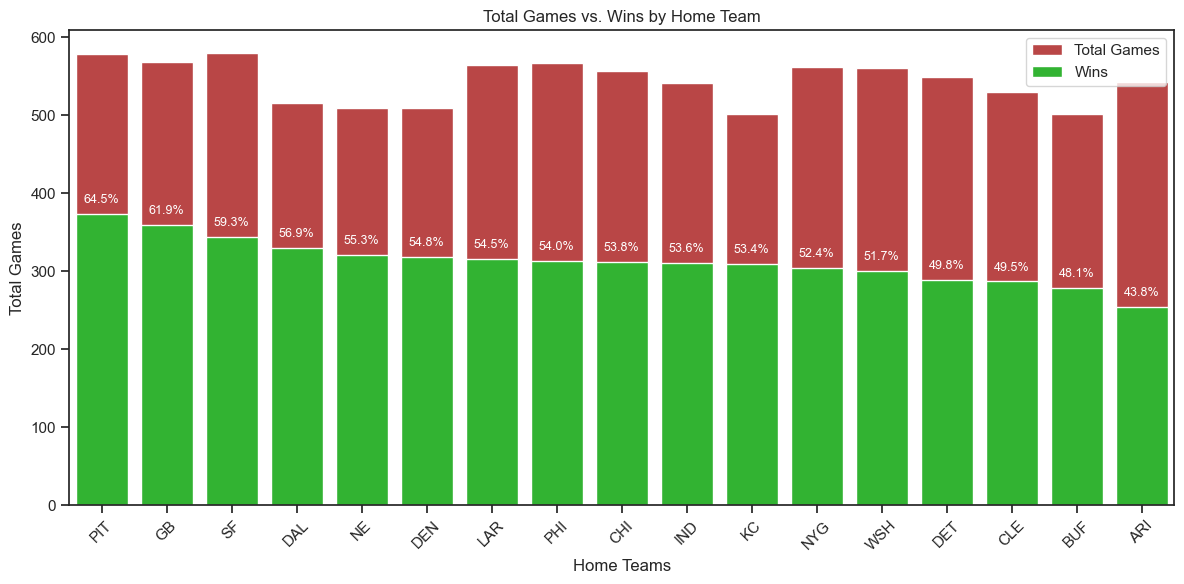

In [69]:
#plot home team chart for top teams
visuals_utility.plot_team_chart(top_home_teams, "Home")

In [70]:
# check the trends of visiting teams and analyze top 20 wins
visit_team_df = pd.DataFrame(visit_team_details)
top_visit_teams = visit_team_df.sort_values(by='wins', ascending=False).iloc[:20]
top_visit_teams['win_per'] = round(((top_visit_teams['wins']/top_visit_teams['total_games']) * 100), 2)
top_visit_teams

,team,average_elo_pre,average_elo_prob,total_games,wins,LR_accuracy,win_per
14,SF,1525.839429,0.444179,561,264,0.65248,47.06
13,PIT,1540.054376,0.464596,564,264,0.64539,46.81
6,IND,1513.353711,0.425464,551,258,0.71014,46.82
3,DAL,1551.721267,0.474702,510,256,0.63281,50.20
5,GB,1534.387886,0.448853,571,255,0.69930,44.66
11,NYG,1503.154128,0.410911,559,253,0.62143,45.26
8,LAR,1513.929904,0.430218,569,252,0.64336,44.29
12,PHI,1511.604505,0.427235,560,245,0.66429,43.75
10,NE,1534.901809,0.462464,501,241,0.64286,48.10
16,WSH,1493.598667,0.403895,558,234,0.56429,41.94


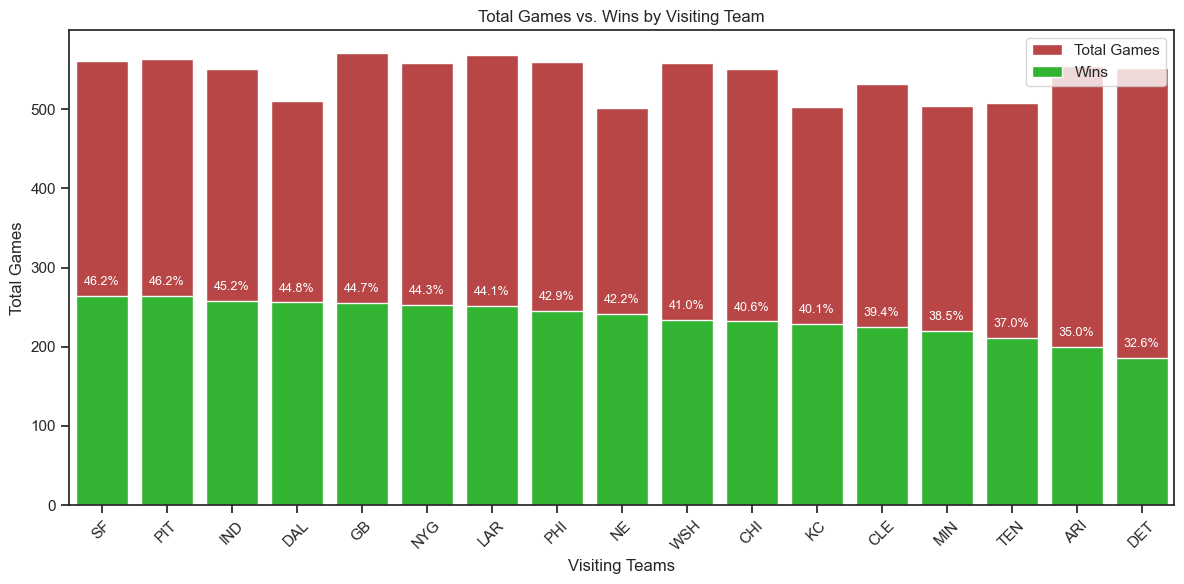

In [71]:
#plot visiting team chart for top teams
visuals_utility.plot_team_chart(top_visit_teams, "Visiting")

We can see that Home teams have more advantage and wins compared to visiting teams. 

### Let us see how the Logistic Regression scored when we processed data for each team separately.

In [72]:
def plot_accuracy_scores(gteam_df, teamType):
    '''
    '''
    color_palette = color_utility.color_palettes['dark_mango'][:len(gteam_df)]

    plt.figure(figsize=(10, 6))
    bars = sns.barplot(data=gteam_df, y='LR_accuracy', x='team', palette=color_palette)

    for p in bars.patches:
        bars.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
    
    plt.ylim(top=1.0)

    plt.title(f'Logistic Regression Accuracy Scores by {teamType} Teams')
    plt.xlabel('Teams')
    plt.ylabel('Accuracy Scores')

    plt.show()

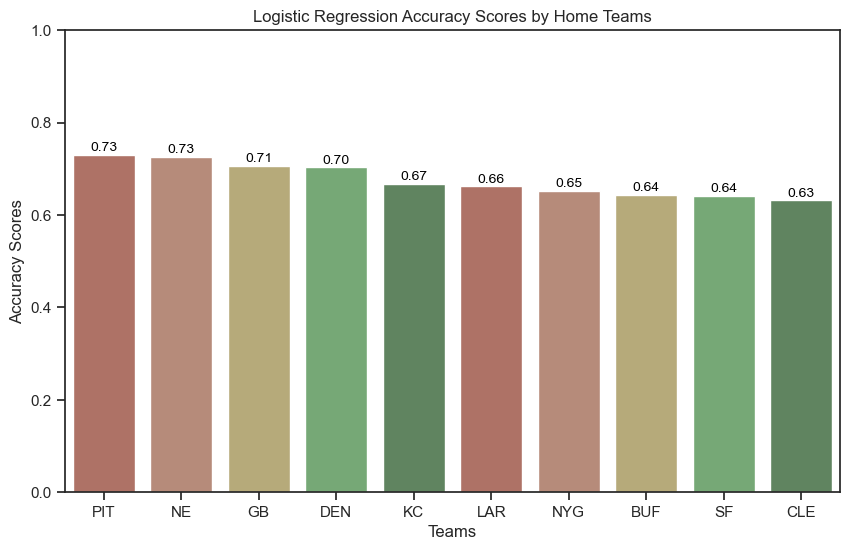

In [73]:
# plot accuracy scores of top 10 teams
plot_accuracy_scores(top_home_teams.sort_values(by='LR_accuracy', ascending=False).iloc[:10], "Home")

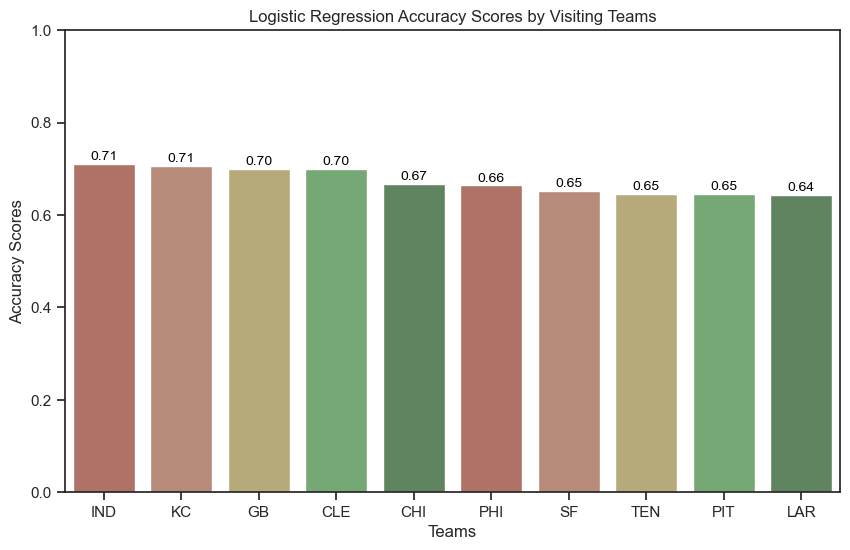

In [74]:
# plot accuracy scores of top 10 teams
plot_accuracy_scores(top_visit_teams.sort_values(by='LR_accuracy', ascending=False).iloc[:10], "Visiting")